# Audio Effects Classification using Support-vector Machine

In [451]:
import numpy as np
import librosa
import os
import sklearn.svm
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif,f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from tqdm.notebook import tqdm
from IPython.display import Audio
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import cross_val_score


# Load Files and Create Lables

In [452]:
root = '/Users/Progetti Programmazione/PyCharm/CMLS/HW1/Dataset/IDMT-SMT-AUDIO-EFFECTS/Gitarre monophon/Samples'
classes = []
fileList = []
fileLable = []



sub_dirs = [x[0] for x in os.walk(root)]

for sub_dir in sub_dirs[1:]:
    className = os.path.basename(sub_dir) # return the last term of path
    classes.append(className)
    
    prog_bar = tqdm(desc='Loading audio samples')
    prog_bar.reset(total=len(os.listdir(sub_dir))) 
    
    file_list = [f for f in os.listdir(sub_dir) if f.endswith('.wav')]
    
    for f in file_list:
        fileList.append(os.path.join(sub_dir,f))
        fileLable.append(className)
        prog_bar.update()
    
    prog_bar.refresh();

print(classes)
len(fileList)

Loading audio samples: 0it [00:00, ?it/s]

Loading audio samples: 0it [00:00, ?it/s]

Loading audio samples: 0it [00:00, ?it/s]

['Tremolo', 'NoFX', 'Distortion']


4368

# Compute Features

In [455]:
def featuresList(): #List of all the computed features
    return [
        'Average Centroid', 'Rolloff','Flatness', 'Zero crossing rate', 'Mfc1', 'Mfc2', 'Mfc3', 'Mfc4',
        'Mfc5', 'Mfc6', 'Mfc7', 'Mfc8', 'Mfc9', 'Mfc10', 'Mfc11', 'Mfc12', 'Mfc13', 'Mfc14', 'Mfc15', 'Mfc16',
        'Mfc17', 'Mfc18', 'Mfc19', 'Mfc20', 'Mfc21', 'Mel1', 'Mel2','Mel3','Mel4','Mel5','Mel6','Mel7','Mel8','Mel9',
        'Mel10','Mel11','Mel12','Mel13','Mel14','Mel15','Mel16','Mel17','Mel18','Mel19','Mel20','Mel21','Mel22','Mel23',
        'Mel24','Mel25','Mel26','Mel27','Mel28','Mel29','Mel30','Mel31','Mel32','Mel33','Mel34','Mel35','Mel36','Mel37',
        'Mel38','Mel39','Mel40','Cont1','Cont2','Cont3','Cont4','Cont5','Cont6','Cont7']


In [476]:
window_parameters={
    'n_fft': 1024,
    'hop_length': 512,
    #'win_length':2048,
    'window': 'hamming',
    'center': True
}

n_mels = 40
n_mfcc = 21

samples = len(fileList)
features = np.zeros((samples, 72))

prog_bar = tqdm(desc='Loading audio samples')
prog_bar.reset(total=samples)



for index, f in enumerate(fileList): 
    # Step1: load audio
    audio, fs = librosa.load(f, sr=None)
    
    audio = audio/(np.abs(audio).max())

    
    #Step2: compute features
    speCen = np.array([np.average(librosa.feature.spectral_centroid(y=audio, sr=fs, **window_parameters))])
    
    speRol = np.array([np.nanmean(np.trim_zeros(librosa.feature.spectral_rolloff(y=audio, sr=fs, **window_parameters)[0]))])
   
    speFla = np.array([np.nanmean(np.trim_zeros(librosa.feature.spectral_flatness(y=audio,
                                                 **window_parameters)[0]))])
    zcr = np.array([np.max(librosa.feature.zero_crossing_rate(y=audio,
                                                         hop_length=window_parameters.get('hop_length')))])

    mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=fs, **window_parameters,
                                n_mfcc=n_mfcc,norm='ortho'), axis=1)
    mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=fs, **window_parameters,
                                        n_mels=n_mels), axis = 1)
    speCon = np.mean(librosa.feature.spectral_contrast(y=audio, sr=fs, **window_parameters), axis=1)
    
    
    feature = np.concatenate((mel, mfcc, speCon, speCen, speRol, speFla, zcr), axis=0)
    features[index, :] = feature 
    
  
    prog_bar.update()
    
prog_bar.refresh();





Loading audio samples: 0it [00:00, ?it/s]

In [360]:

features_list = featuresList()



df = pd.DataFrame(features,
                   columns=features_list)







# Split Train-Test


In [477]:

from sklearn.model_selection import train_test_split, cross_val_score
X_train,X_test,y_train,y_test = train_test_split(features, fileLable, test_size = 0.20)
print(X_train.shape, X_test.shape)






(3494, 72) (874, 72)


# Features Normalization


In [478]:
#separate Normalization

mms = MinMaxScaler()
X_train_std = mms.fit_transform(X_train)
X_test_std = mms.transform(X_test)

# PCA

In [417]:
#pca = PCA(n_components=10)
#X_train_std = pca.fit_transform(X_train_std)
#X_test_std = pca.transform(X_test_std)
#print(X_train_std)

[[-1.01883865 -0.02713224 -0.16725198 ... -0.00728244 -0.08075243
  -0.0631188 ]
 [ 0.24229355  0.35675357  0.53908808 ...  0.05140837  0.12032055
  -0.03806827]
 [-0.63199815  0.08592605 -0.31404134 ... -0.06025414  0.03783126
   0.11036473]
 ...
 [-0.31424784 -0.30918029  0.07421802 ...  0.14805857 -0.00425208
  -0.25660788]
 [-0.86830755  0.19242047 -0.1515498  ...  0.10729558 -0.08415814
  -0.04829377]
 [ 0.88250306  0.00984324  0.19927311 ...  0.020369   -0.18225038
  -0.10006819]]


# Selection of K Best Features


In [499]:
#Features selection on Training set
features_selector = SelectKBest(chi2, k=2)
X_train_sel_features = features_selector.fit_transform(X_train_std, y_train)
selected_columns = features_selector.get_support(indices=True)
print(selected_columns)
print(X_train_sel_features)


selected_features_names = []
i = 0
for column in selected_columns:
    current_selected_feature = features_list[column]
    selected_features_names.append(current_selected_feature)
    i=i+1
print(selected_features_names) #List of the k best features names


X_test_sel_features = features_selector.transform(X_test_std)
#X_test_sel_features = X_test_norm[:,selected_columns] #filtering the features in Testing set
                                                      #based on K best features computed on the Training set






[40 70]
[[0.05080999 0.32897286]
 [0.28469243 0.69000968]
 [0.70886308 0.0859428 ]
 ...
 [0.60491624 0.07734564]
 [0.36444872 0.42673926]
 [0.66199446 0.0837447 ]]
['Mel16', 'Cont6']


# SVM: multiclass case

## Define and train a model

In [500]:

#SVM Model
SVM_parameters={
    'C': 100,
    'kernel': 'rbf', #rbf, poly
    'gamma' : 1,
    'class_weight':'balanced'
    
}

ss = sklearn.svm.SVC(**SVM_parameters, probability=True)
ss.fit(X_train_sel_features, y_train)
accuracySVM = ss.score(X_test_sel_features, y_test)
print("The SVM accuracy is",format(accuracySVM))



The SVM accuracy is 0.9084668192219679


## Evaluate and Output the Confusion Matrix

Confusion matrix
[[367   0   0]
 [  0  70  42]
 [  3  59 333]]
Normalized confusion matrix
[[1.         0.         0.        ]
 [0.         0.625      0.375     ]
 [0.00759494 0.14936709 0.84303797]]


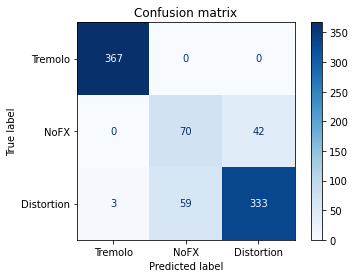

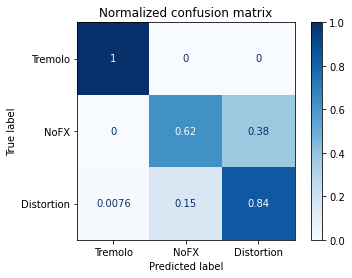

In [498]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

titles_options = [("Confusion matrix", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(ss, X_test_sel_features, y_test,
                                 display_labels=classes,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()
